In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import yaml

In [54]:
from catboost import CatBoostRegressor
from catboost import Pool
from sklearn.model_selection import  train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    matthews_corrcoef,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)
import shap
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

In [55]:
def score_regression_simple(target, predictions,) -> pd.DataFrame:
    '''
    Функция для подсчета метрик
    '''
    predictions = np.array(predictions)

    metrics = {
        "R2":       round(r2_score(target, predictions),3),
        "MAE":  round(mean_absolute_error(target, predictions),3),
        "MSE":  round(mean_squared_error(target, predictions),3),
        "RMSE":   round((np.sqrt(mean_squared_error(target, predictions))),3),
        "MAPE":        round(mean_absolute_percentage_error(target, predictions),3),
        } 
    return metrics

In [56]:
def calc_min_price_rolling(data, delta_h=24, features=None):
    if features is None:
        features = ['rarity', 'genesis', 'sneaker_type', 'level', 'mint']

    result = np.zeros(len(data))

    for i in range(len(data)):
        #i = 156
        sample = data.iloc[i]
        data_tmp = data.iloc[:i]
        data_tmp = data_tmp[data_tmp['date'] > (sample['date'] - pd.Timedelta(delta_h, unit='h'))]

        for feature in features:
            data_tmp = data_tmp[(data_tmp[feature] == sample[feature])]
        result[i] = data_tmp['price'].min()
    
    return result

In [57]:
!pip freeze > requirements.txt

# SETUP

In [58]:
CONFIG_DIR = '../app/'

In [59]:
with open(f"{CONFIG_DIR}config_prod.yml", 'r') as ymlfile:
    config = yaml.load(ymlfile, Loader=yaml.SafeLoader)

In [60]:
BD_NAME = f'{config["DATASET"]}.csv'
BD_FOLDER = './data'
VERSION = config["VERSION"]
START_DATE = '2022-09-03'
TETS_DATE = '2022-09-30'

In [61]:
data_quality_expected_range_dict = {
    'sneaker':
        {
        #'is_type': {'genesis': bool},
        'is_in':
            {
            'rarity': ['common', 'uncommon', 'rare'],
            'sneaker_type': ['ranger', 'sprinter', 'hiker', 'coacher'],
            },
        'min_max':
            {
            'level': [0, 30],
            'base_performance': [0, 40],
            'base_fortune': [0, 40],
            'base_joy': [0, 40],
            'base_durability': [0, 40],
            'performance': [0, 500],
            'fortune': [0, 300],
            'joy': [0, 300],
            'durability': [0, 300],
            'mint': [0, 7],
            'buy_count_12H': [0, 500],
            'buy_count_24H': [0, 1000],
            'sell_count_24H': [0, 2000],
            'cancel_count_24H': [0, 1000],
            #'token_all_activity_3H': [0, 30],
            #'token_sell_activity_6H': [0, 30],
            },
        }
}

# DATA

In [62]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')
data

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664882710,49829,29841,sell,0x287a3187a2b5584f8f8798ec36f45cc2336d7b74,NaN,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,395.0,453.0,100.0,553.0
1,1664882656,49828,40251,sell,0x4295e2baeb32a09c039f9473f9bd5d7074d38649,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,93.0,138.0,252.0,394.0,452.0,100.0,552.0
2,1664882641,49827,21513,sell,0xea16bf173dd03fc75961cc9b31b3ab1734528c60,NaN,0.77,sneakers,common,hiker,...,0.65,0.62,0.62,44.0,53.0,141.0,393.0,451.0,100.0,551.0
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
4,1664882626,49826,35908,sell,0x550ac8e10d959caad354529c4a2f9f67d2471968,NaN,0.84,sneakers,common,sprinter,...,0.62,0.62,0.62,92.0,137.0,251.0,393.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71918,1661029606,13798,24335,sell,0x0d4eafe1ed97f590fde02c21dcf2b0ae6cb106d7,NaN,0.90,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71919,1661029594,13797,27211,sell,0xb83b40609684191abba9184f627a112df5ac0a44,NaN,0.92,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71920,1661029585,13596,32513,buy,0x1041f11e1738c5ea8d3ff3c5a1a314a617313ee1,0x2eeedd73169a17e4f79a6d6bea238f11b05238e4,0.92,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71921,1661029462,13796,32779,sell,0x668ff3191878ed0f7112031305eccb1d79a865e4,NaN,1.00,sneakers,common,sprinter,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [64]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71923 entries, 0 to 71922
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  43892 non-null  float64
 1   time_ownership             43892 non-null  float64
 2   wallet_box_mint            43892 non-null  float64
 3   wallet_sneaker_mint        43892 non-null  float64
 4   time_level_up              46377 non-null  float64
 5   time_level_up_for_mint     50215 non-null  float64
 6   base_mint_price_amt        50215 non-null  float64
 7   base_mint_price_azy        50215 non-null  float64
 8   base_mint_price_bnb        40192 non-null  float64
dtypes: float64(9)
memory usage: 4.9 MB


In [65]:
data.genesis

0         True
1        False
2         True
3         True
4        False
         ...  
71918     True
71919    False
71920    False
71921    False
71922     True
Name: genesis, Length: 71923, dtype: bool

In [66]:
data = data[(data.item_type == 'sneakers') & (data.event == 'buy')].copy()
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# data_quality

In [67]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    for element in data[feature].unique():
        if element not in dq[feature]:
            print(f'{feature} not in data_quality_expected_range_dict. get {element}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if data[feature].isna().sum() > 0:
        print(f'Nans in {feature}')

    if data[feature].min() < dq[feature][0]:
        print(f'{feature} less then expected. get: {data[feature].max()} | expected: {dq[feature][0]}')

    if data[feature].max() > dq[feature][1]:
        print(f'{feature} more then expected. get: {data[feature].max()} | expected: {dq[feature][1]}')

buy_count_12H more then expected. get: 567.0 | expected: 500
cancel_count_24H more then expected. get: 1348 | expected: 1000


In [68]:
data['mint'].isna().sum()

0

In [69]:
data[data['level'] == 9]['mint'].value_counts()

2.0    263
0.0     77
3.0     62
1.0     36
4.0      3
Name: mint, dtype: int64

In [70]:
data[data['level'] > 10]

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
33,1664881293,49347,15226,buy,0x5a181a86735b86c6f2bc3784eb85d641af123254,0x132dfb2f49a3ded8fdda487068f728ed5bfb0cdc,1.80,sneakers,common,sprinter,...,0.74,0.62,0.62,8.0,14.0,143.0,389.0,449.0,100.0,549.0
107,1664876399,42854,30719,buy,0x43b4a29b8b0f23663b774d592418a2e1c164661d,0x2887e940b96dd95a208370ea9cfc29c7efd9fe16,1.00,sneakers,common,hiker,...,0.59,0.59,0.59,9.0,11.0,251.0,389.0,452.0,102.0,554.0
353,1664863134,49319,23677,buy,0x391c55600b21b18010cb5d7f3ee7054d6fad3973,0xf8744ddd83a5a76591e76301da04c2da179afcd3,2.00,sneakers,common,ranger,...,0.64,0.59,0.59,7.0,12.0,127.0,361.0,412.0,102.0,514.0
465,1664854173,47280,15404,buy,0x2dc06afefd4723048ae903b75dfbe405cb696a69,0x0f62f746347963ac8cbe03f6b9d980ff194dcda3,1.88,sneakers,common,coacher,...,0.63,0.61,0.61,8.0,14.0,135.0,378.0,436.0,101.0,537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67295,1661371295,16118,15092,buy,0x418a1e05650e9a053754c5688efeccc66690731e,0x05e5052fd465d5f5de2d7c0b230967ecb28518b8,0.90,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68071,1661322877,15730,14692,buy,0xf6389b738e12464d401b576290dc1406bf5d3b0a,0x56bc8d10982e09d99cfb67fa3cbca2bfb0dc4525,1.50,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69224,1661232037,15161,23928,buy,0x888f37fa33e5ed1a91e7b288cab38f051588ae2a,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,7.66,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69585,1661191945,14985,23928,buy,0xeea6fe3d490b421a9448adaf346e4d7bd13fa287,0xf3df1c64cb2e66400ef968caabfbe665457d25d4,1.70,sneakers,uncommon,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [72]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   wallet_first_sneaker_time  12967 non-null  float64
 1   time_ownership             12967 non-null  float64
 2   wallet_box_mint            12967 non-null  float64
 3   wallet_sneaker_mint        12967 non-null  float64
 4   time_level_up              12967 non-null  float64
 5   time_level_up_for_mint     12967 non-null  float64
 6   base_mint_price_amt        12967 non-null  float64
 7   base_mint_price_azy        12967 non-null  float64
 8   base_mint_price_bnb        10577 non-null  float64
dtypes: float64(9)
memory usage: 1013.0 KB


In [73]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
3,1.657811e+09,636768.0,7.0,7.0,900.0,1800.0,300.0,200.0,0.442615
15,1.658155e+09,53456.0,14.0,24.0,11400.0,1800.0,1200.0,800.0,1.763929
16,1.663132e+09,270.0,4.0,8.0,900.0,1800.0,300.0,200.0,0.441212
17,1.664770e+09,756.0,1.0,1.0,900.0,1800.0,300.0,200.0,0.441212
30,1.659549e+09,1002238.0,13.0,13.0,900.0,1800.0,300.0,200.0,0.440034
...,...,...,...,...,...,...,...,...,...
71860,1.657803e+09,18915.0,5.0,0.0,900.0,1800.0,300.0,200.0,NaN
71883,1.657800e+09,5178.0,6.0,10.0,900.0,1800.0,300.0,200.0,NaN
71897,1.657800e+09,446391.0,5.0,7.0,900.0,1800.0,300.0,200.0,NaN
71902,1.659970e+09,1062034.0,0.0,1.0,2700.0,1800.0,300.0,200.0,NaN


In [74]:
data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [75]:
#int_columns = ['timestamp', 'mrk_id', 'token_id', 'level', 'mint']
#float_columns = ['performance', 'fortune', 'joy', 'durability', 'price']
#cat_columns = ['item_type', 'rarity', 'sneaker_type',]

In [76]:
#for columns in int_columns:
#    data[columns] = data[columns].astype('int')

# for columns in float_columns:
#     data[columns] = data[columns].astype('float')

#for columns in cat_columns:
#    data[columns] = data[columns].astype('category')

In [77]:
#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12967 entries, 3 to 71916
Data columns (total 81 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   timestamp                                        12967 non-null  int64  
 1   mrk_id                                           12967 non-null  int64  
 2   token_id                                         12967 non-null  int64  
 3   event                                            12967 non-null  object 
 4   wallet_from                                      12933 non-null  object 
 5   wallet_to                                        12967 non-null  object 
 6   price                                            12967 non-null  float64
 7   item_type                                        12967 non-null  object 
 8   rarity                                           12967 non-null  object 
 9   sneaker_type                

In [79]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
3,1664882638,49823,23016,buy,0x7a90ded76bb5ff4991b415f25db78ee72c4996e8,0x4af24870c2f593937ffd8d52ba0ae0895dd21805,0.65,sneakers,common,hiker,...,0.65,0.62,0.62,45.0,54.0,142.0,394.0,452.0,100.0,552.0
15,1664882238,49416,37493,buy,0xba66c77c523624341a1f8961812cb74ddd4e35bd,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,3.70,sneakers,uncommon,hiker,...,1.72,1.72,0.62,2.0,2.0,49.0,56.0,450.0,100.0,550.0
16,1664882082,49816,48699,buy,0xf33443dd0bd01dbfeed406cd37148941e76496fe,0xe08ce97b21d4d92871c00315fe9a984e879d7cbe,0.61,sneakers,common,sprinter,...,0.61,0.61,0.61,13.0,137.0,249.0,390.0,451.0,100.0,551.0
17,1664882046,49818,65273,buy,0xd3b1cc01a0ce14e709bac7c28b0bfeddff163bcf,0x0e771bf8425a5633972c4550ee916b870eb7f728,0.90,sneakers,common,ranger,...,0.61,0.61,0.61,33.0,138.0,250.0,391.0,451.0,100.0,551.0
30,1664881458,49811,57020,buy,0x7de958927f1247936b977dc24604438e8a1fe7d2,0x52aede929fea19342d6e63d600e88064d3b84e99,0.63,sneakers,common,hiker,...,0.62,0.62,0.62,13.0,136.0,248.0,391.0,451.0,100.0,551.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71860,1661037238,13786,18163,buy,0x53d77d21ebf48461514dc4399f53e1dd4fd36067,0x4bba52eabf7c05c20f0406411f2107832ccdda0f,0.97,sneakers,common,coacher,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71883,1661035060,13801,17327,buy,0x5357ef225250a79fed6de8e925d2ad4fc88d461f,0x7417ce741427022821a39d691e6a2613ff48f17a,1.10,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71897,1661032615,13731,27159,buy,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0x1452911e6f252ab94809266a3934dfd89c77b708,1.25,sneakers,common,hiker,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71902,1661031799,13694,20002,buy,0x7417ce741427022821a39d691e6a2613ff48f17a,0x136f85ed70bbd9476c9175388e79e2456b8e043e,1.30,sneakers,common,ranger,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

 фильтруем то что мы уже купили

In [81]:
len(data)

12967

In [82]:
data = data[data['wallet_to'] != '0x3273af210822c44afd7254510e612e4dbb1040a7']
len(data)

12758

уберем выбросы

In [83]:
data = data[(data['price'] > 0.3)]
len(data)

12754

In [84]:
data = data[~((data['genesis']) & (data['price'] < 0.4))].copy()
len(data)

12754

In [85]:
#len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

In [86]:
#train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()

# ML

## FE

In [87]:
# data['bin_level'] = data['level'].replace({
# 0: 0,
# 1: 1, 2: 1, 3: 1, 4: 1, 
# 5: 2, 
# 6: 3, 7: 3, 8: 3,
# 9: 4, 
# 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5,
# 16: 6, 17: 6, 18: 6, 19: 6,
# 20: 7, 21: 7, 22: 7, 23: 7, 24: 7, 25: 7, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7,
# }).copy()

# data['bin_mint'] = data['mint'].replace({
# 0: 0,
# 1: 1, 
# 2: 2, 
# 3: 3, 4: 3, 5: 3, 6: 3, 7: 3, 
# }).copy()

In [88]:
#data['bin_level'].value_counts()

In [89]:
#data['bin_mint'].value_counts()

In [90]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_24H'] = calc_min_price_rolling(data, delta_h=24, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_48H'] = calc_min_price_rolling(data, delta_h=48, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_72H'] = calc_min_price_rolling(data, delta_h=72, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [91]:
#data['min_price_by_rarity_genesis_type_bin_level_mint_12H'] = calc_min_price_rolling(data, delta_h=12, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])
#data['min_price_by_rarity_genesis_type_bin_level_mint_6H'] = calc_min_price_rolling(data, delta_h=6, features = ['rarity', 'sneaker_type', 'genesis', 'bin_mint', 'bin_level'])

In [92]:
#data['min_price_by_rarity_genesis_type_level_mint_24H_nan'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].isna()
#data['min_price_by_rarity_genesis_type_24H_nan'] = data['min_price_by_rarity_genesis_type_24H'].isna()

#data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(0)
#data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(0)

data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']

In [93]:
data['token_sell_activity_6H'].max()

11.0

In [94]:
data['min_price_by_rarity_genesis_type_level_mint_24H'] = data['min_price_by_rarity_genesis_type_level_mint_24H'].fillna(np.nan)
data['min_price_by_rarity_genesis_type_24H'] = data['min_price_by_rarity_genesis_type_24H'].fillna(np.nan)

In [95]:
#data['bin_level'] = data['bin_level'].astype(str)
#data['bin_mint'] = data['bin_mint'].astype(str)

# Model

In [96]:
len(data[(data.date >= START_DATE) & (data.date <= TETS_DATE)])

8802

In [97]:
data = data[(data.date >= START_DATE)].copy()
train_data = data[(data.date >= START_DATE) & (data.date <= TETS_DATE)].copy()
test_data = data[(data.date > TETS_DATE)].copy()

In [98]:
train_data[['price_bnb', 'price_azy', 'price_amt','base_mint_price_bnb']]

,price_bnb,price_azy,price_amt,base_mint_price_bnb
55935,277.756081,0.113478,0.552838,0.678822
55934,277.756081,0.113478,0.552838,0.678822
55928,278.034632,0.112454,0.552219,0.676738
55926,278.034632,0.112460,0.552195,0.676716
55914,278.702819,0.112101,0.552725,0.675406
...,...,...,...,...
6589,282.008963,0.059515,0.379102,0.445495
6586,281.981640,0.059638,0.378852,0.445359
6554,282.750666,0.059846,0.378859,0.444303
6552,282.750666,0.059846,0.378859,0.444303


In [99]:
train_data.columns

Index(['timestamp', 'mrk_id', 'token_id', 'event', 'wallet_from', 'wallet_to',
       'price', 'item_type', 'rarity', 'sneaker_type', 'level',
       'base_performance', 'base_fortune', 'base_joy', 'base_durability',
       'performance', 'fortune', 'joy', 'durability', 'mint', 'parent1',
       'parent2', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type',
       'price_bnb', 'price_azy', 'price_amt', 'wallet_from_buy_count',
       'wallet_from_all_count', 'token_all_activity_3H',
       'token_sell_activity_6H', 'buy_count_12H', 'buy_count_24H',
       'buy_count_48H', 'sell_count_12H', 'sell_count_24H', 'sell_count_48H',
       'cancel_count_12H', 'cancel_count_24H', 'cancel_count_48H',
       'min_price_all_24H', 'min_price_by_rarity_genesis_type_level_mint_24H',
       'min_price_by_rarity_genesis_type_level_mint_48H',
       'min_price_by_rarity_genesis_type_level_mint_72H',
       'min_price_by_rarity_genesis_type_24H',
       'min_price_by_rarity_genesis_type_48H',
    

In [100]:
train_data[['price_bnb', 'price_azy', 'price_amt', 'wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb', 'date']]

,price_bnb,price_azy,price_amt,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb,date
55935,277.756081,0.113478,0.552838,1.661425e+09,2.336700e+04,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:06:43
55934,277.756081,0.113478,0.552838,1.661425e+09,1.923600e+04,1.0,2.0,900.0,1800.0,300.0,200.0,0.678822,2022-09-03 00:07:58
55928,278.034632,0.112454,0.552219,1.659676e+09,1.420813e+06,5.0,5.0,900.0,1800.0,300.0,200.0,0.676738,2022-09-03 00:22:19
55926,278.034632,0.112460,0.552195,1.661527e+09,5.297780e+05,1.0,1.0,900.0,1800.0,300.0,200.0,0.676716,2022-09-03 00:23:43
55914,278.702819,0.112101,0.552725,1.657802e+09,2.278671e+06,1.0,1.0,3300.0,1800.0,300.0,200.0,0.675406,2022-09-03 00:55:37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6589,282.008963,0.059515,0.379102,1.658063e+09,1.475460e+05,1.0,2.0,2700.0,1800.0,300.0,200.0,0.445495,2022-09-29 22:52:13
6586,281.981640,0.059638,0.378852,0.000000e+00,1.664492e+09,0.0,0.0,1260.0,1800.0,300.0,200.0,0.445359,2022-09-29 22:58:49
6554,282.750666,0.059846,0.378859,1.657800e+09,6.307800e+04,12.0,10.0,0.0,1800.0,300.0,200.0,0.444303,2022-09-29 23:30:35
6552,282.750666,0.059846,0.378859,1.658847e+09,1.303555e+06,14.0,17.0,900.0,1800.0,300.0,200.0,0.444303,2022-09-29 23:31:29


In [101]:
train_data.base_mint_price_azy.value_counts()

200.0     8221
800.0      573
3200.0       8
Name: base_mint_price_azy, dtype: int64

In [102]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    #'bin_level',
    #'bin_mint',
    #'wallet_from_buy_count',
    #'wallet_from_all_count',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    #'buy_count_12H',
    'buy_count_24H',
    'min_price_all_24H',
    #'sum_activity_24H',
    'sells_activity_24H',
    #'min_price_by_rarity_genesis_type_level_mint_24H',
    'min_price_by_rarity_genesis_type_level_mint_48H',
    #'min_price_by_rarity_genesis_type_level_mint_72H',
    'min_price_by_rarity_genesis_type_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_6H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_24H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_48H',
    #'min_price_by_rarity_genesis_type_bin_level_mint_72H',
    #'min_price_by_rarity_genesis_type_48H',
    #'min_price_by_rarity_genesis_type_72H',
    #'token_all_activity_3H',
    #'token_sell_activity_6H',
    #'wallet_first_sneaker_time',
    #'time_ownership', 
    #'wallet_box_mint', 
    #'wallet_sneaker_mint',
    'time_level_up', 
    #'time_level_up_for_mint', 
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    'base_mint_price_bnb',
    'price_bnb', 
    'price_azy', 
    'price_amt',
    ]
cat_features = [0, 1, 2,]
# cat_features = [
#     'rarity',
#     'sneaker_type',
#     'genesis',
#     'bin_level',
#     'bin_mint',
#     ]


In [103]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [104]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    model = CatBoostRegressor(
        #depth=5,
        #loss_function='MAPE',
        random_seed=42
        )

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.37s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:07,  2.36s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:09,  2.35s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:11,  2.35s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:14,  2.35s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:16,  2.34s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:18,  2.35s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:21,  2.34s/it]iteritems is deprec

In [105]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.923,0.0482
MAE,0.085,0.0109
MSE,0.098,0.1020
RMSE,0.290,0.1182
MAPE,0.062,0.0028


In [106]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.923,0.0482
MAE,0.085,0.0109
MSE,0.098,0.1020
RMSE,0.290,0.1182
MAPE,0.062,0.0028


In [107]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.914, 'MAE': 0.085, 'MSE': 0.098, 'RMSE': 0.313, 'MAPE': 0.062}

In [108]:
# Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


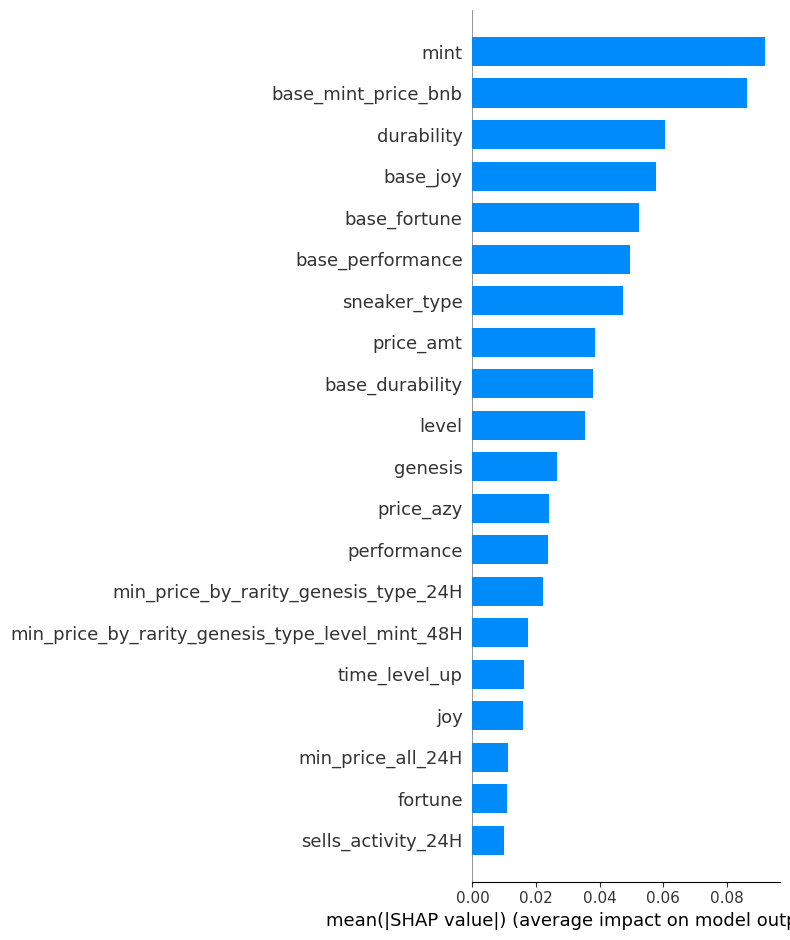

In [109]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## TEST

In [110]:
model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X_train, y_train, cat_features=cat_features,)
#model.save_model(f'./models/sneaker_model_{VERSION}.model')

Learning rate set to 0.057733
0:	learn: 1.0227657	total: 4.13ms	remaining: 4.13s
1:	learn: 0.9801532	total: 7.61ms	remaining: 3.79s
2:	learn: 0.9432397	total: 10.3ms	remaining: 3.43s
3:	learn: 0.9043853	total: 12.8ms	remaining: 3.2s
4:	learn: 0.8696787	total: 15.1ms	remaining: 3.01s
5:	learn: 0.8361162	total: 17.5ms	remaining: 2.9s
6:	learn: 0.8036932	total: 19.8ms	remaining: 2.81s
7:	learn: 0.7734457	total: 22.1ms	remaining: 2.74s
8:	learn: 0.7450759	total: 24.4ms	remaining: 2.69s
9:	learn: 0.7161701	total: 26.8ms	remaining: 2.66s
10:	learn: 0.6913790	total: 29.1ms	remaining: 2.61s
11:	learn: 0.6693642	total: 31.5ms	remaining: 2.59s
12:	learn: 0.6465122	total: 33.8ms	remaining: 2.57s
13:	learn: 0.6245179	total: 36.2ms	remaining: 2.55s
14:	learn: 0.6051158	total: 38.5ms	remaining: 2.53s
15:	learn: 0.5869083	total: 40.7ms	remaining: 2.5s
16:	learn: 0.5676830	total: 43.2ms	remaining: 2.5s
17:	learn: 0.5495213	total: 45.6ms	remaining: 2.48s
18:	learn: 0.5338997	total: 48ms	remaining: 2.48

In [111]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

{'R2': 0.888, 'MAE': 0.104, 'MSE': 0.051, 'RMSE': 0.226, 'MAPE': 0.111}

In [112]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.888, 'MAE': 0.104, 'MSE': 0.051, 'RMSE': 0.226, 'MAPE': 0.111}

In [113]:
pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

iteritems is deprecated and will be removed in a future version. Use .items instead.


{'R2': 0.888, 'MAE': 0.104, 'MSE': 0.051, 'RMSE': 0.226, 'MAPE': 0.111}

## Fit full Model

In [114]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

model = CatBoostRegressor(random_seed=42,)

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058982
0:	learn: 0.9839577	total: 3.55ms	remaining: 3.54s
1:	learn: 0.9422153	total: 7.03ms	remaining: 3.51s
2:	learn: 0.9005787	total: 10.2ms	remaining: 3.38s
3:	learn: 0.8624180	total: 13.1ms	remaining: 3.26s
4:	learn: 0.8273982	total: 15.8ms	remaining: 3.15s
5:	learn: 0.7940810	total: 18.6ms	remaining: 3.09s
6:	learn: 0.7619036	total: 21.8ms	remaining: 3.09s
7:	learn: 0.7333795	total: 24.4ms	remaining: 3.02s
8:	learn: 0.7067140	total: 27ms	remaining: 2.97s
9:	learn: 0.6797263	total: 30ms	remaining: 2.97s
10:	learn: 0.6546332	total: 32.7ms	remaining: 2.94s
11:	learn: 0.6337118	total: 35.5ms	remaining: 2.92s
12:	learn: 0.6130458	total: 38ms	remaining: 2.89s
13:	learn: 0.5930735	total: 40.7ms	remaining: 2.86s
14:	learn: 0.5739870	total: 43.4ms	remaining: 2.85s
15:	learn: 0.5559285	total: 46ms	remaining: 2.83s
16:	learn: 0.5380322	total: 48.7ms	remaining: 2.81s
17:	learn: 0.5198705	total: 51.6ms	remaining: 2.82s
18:	learn: 0.5048846	total: 54.7ms	remaining: 2.82s


### Test

In [115]:
i=1800

In [116]:
sneaker_dict = {}

features = data.columns

for feature in features:
    sneaker_dict[feature] = data.iloc[i][feature]

sneaker_dict['sum_activity_24H'] = sneaker_dict['buy_count_24H'] + sneaker_dict['sell_count_24H'] + sneaker_dict['cancel_count_24H']
sneaker_dict['sells_activity_24H'] = sneaker_dict['sell_count_24H'] / sneaker_dict['buy_count_24H']

sample = pd.Series(sneaker_dict)
sample[model.feature_names_]

rarity                                                 common
sneaker_type                                         sprinter
genesis                                                 False
level                                                     0.0
base_performance                                          8.9
base_fortune                                              8.0
base_joy                                                  7.4
base_durability                                           3.8
performance                                               8.9
fortune                                                   8.0
joy                                                       7.4
durability                                                3.8
mint                                                      0.0
buy_count_24H                                             319
min_price_all_24H                                         0.7
sells_activity_24H                                   1.830721
min_pric

In [117]:
dq = data_quality_expected_range_dict['sneaker']['is_in']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] not in dq[feature]:
        print(f'{feature} not in data_quality_expected_range_dict. get {sneaker_dict[feature]}')

dq = data_quality_expected_range_dict['sneaker']['min_max']
for feature in dq.keys():
    if sneaker_dict[feature] is None:
        print(f'Nans in {feature}')

    if sneaker_dict[feature] < dq[feature][0]:
        print(f'{feature} less then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][0]}')

    if sneaker_dict[feature] > dq[feature][1]:
        print(f'{feature} more then expected. get: {sneaker_dict[feature]} | expected: {dq[feature][1]}')

In [118]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

sample = pd.Series(sneaker_dict)
predict_price = model.predict(sample[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

0.862

In [119]:
data.iloc[i]['price']

0.83

iteritems is deprecated and will be removed in a future version. Use .items instead.


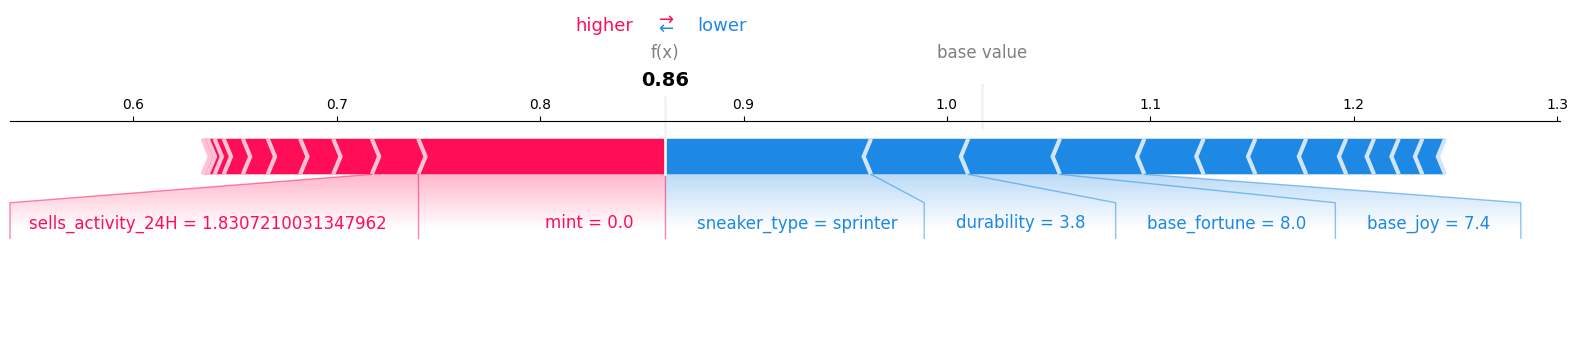

In [120]:
sample = pd.Series(sneaker_dict)
sample = pd.DataFrame(sample[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
#shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

# Base Model

In [121]:
features = [
    'rarity',
    'sneaker_type',
    'genesis',
    'level',
    'base_performance',
    'base_fortune',
    'base_joy',
    'base_durability',
    'performance',
    'fortune',
    'joy',
    'durability',
    'mint',
    ]
cat_features = [0, 1, 2]

In [122]:
X = data[features].copy().reset_index(drop=True)
y = data.price.copy().reset_index(drop=True)

X_train = train_data[features].copy().reset_index(drop=True)
y_train = train_data.price.copy().reset_index(drop=True)

X_test = test_data[features].copy().reset_index(drop=True)
y_test = test_data.price.copy().reset_index(drop=True)

In [123]:
X.genesis.value_counts()

False    7383
True     2696
Name: genesis, dtype: int64

In [124]:
X

,rarity,sneaker_type,genesis,level,base_performance,base_fortune,base_joy,base_durability,performance,fortune,joy,durability,mint
0,common,ranger,False,5.0,8.0,7.4,5.0,2.5,27.0,10.9,7.5,4.0,0.0
1,common,ranger,False,5.0,7.8,9.9,6.2,2.5,26.8,14.9,9.2,4.0,0.0
2,common,ranger,False,5.0,8.0,4.0,2.9,4.9,27.0,6.0,4.4,7.4,2.0
3,common,ranger,False,5.0,8.3,7.6,1.0,9.6,18.3,20.6,1.5,14.6,2.0
4,common,hiker,True,10.0,6.3,8.6,9.0,5.1,34.3,17.3,18.0,18.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10074,common,hiker,False,5.0,8.7,3.3,1.8,3.2,28.2,4.8,2.8,4.7,3.0
10075,common,ranger,False,5.0,9.5,4.2,9.0,9.2,29.5,6.2,13.5,13.7,0.0
10076,common,sprinter,False,5.0,7.9,7.9,3.5,7.5,16.9,14.9,9.5,14.5,3.0
10077,uncommon,hiker,False,19.0,17.6,19.8,19.2,12.4,136.8,57.8,55.3,45.2,2.0


In [125]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X_train, y_train)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
    val_x, val_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     iterations=1000,
    #     learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(train_x, train_y,
                #eval_set=(X_test, y_test),
                cat_features=cat_features,
                #plot=True,
                verbose=False,
                )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:02,  2.13s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:04,  2.13s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:06,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:08,  2.11s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:10,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:12,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:14,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:16,  2.12s/it]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:19,  2.13s/it]iteritems is deprec

In [126]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.834,0.0476
MAE,0.171,0.0127
MSE,0.180,0.0440
RMSE,0.421,0.0534
MAPE,0.152,0.0058


In [127]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.834,0.0476
MAE,0.171,0.0127
MSE,0.180,0.0440
RMSE,0.421,0.0534
MAPE,0.152,0.0058


In [128]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.843, 'MAE': 0.171, 'MSE': 0.18, 'RMSE': 0.424, 'MAPE': 0.152}

In [129]:
# # Create a dataframe of feature importance 
# df_feature_importance = pd.DataFrame(model.get_feature_importance(prettified=True,))
# #plotting feature importance
# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")
# plt.title('features importance')
# plt.show()

iteritems is deprecated and will be removed in a future version. Use .items instead.


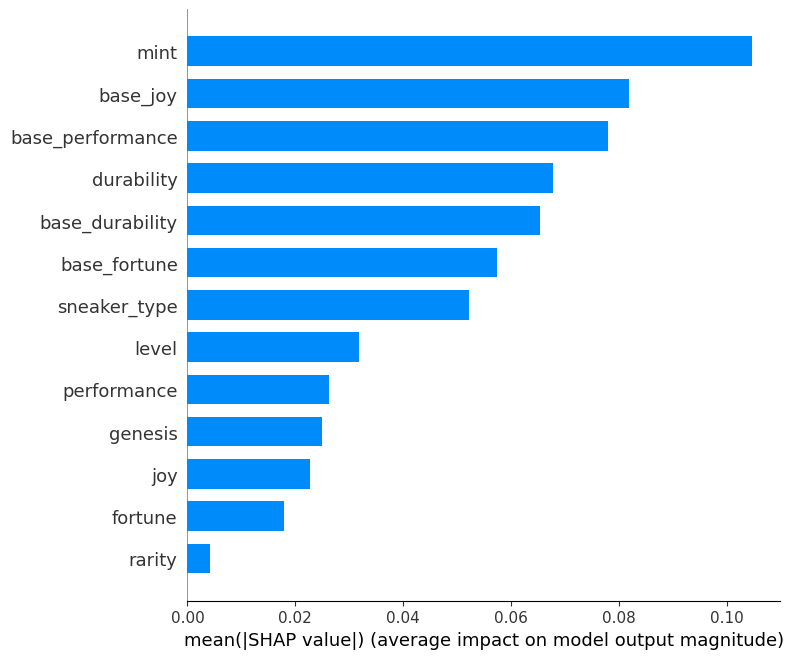

In [130]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

In [131]:
#shap.summary_plot(shap_values, train_x,)

## TEST

In [132]:
model = CatBoostRegressor(random_seed=42,)
model.fit(X_train, y_train, cat_features=cat_features,)

pred = model.predict(X_test)
pred = np.round(pred, 2)

score = score_regression_simple(y_test, pred,)
score

Learning rate set to 0.057733
0:	learn: 1.0247906	total: 3.93ms	remaining: 3.92s
1:	learn: 0.9845752	total: 7.78ms	remaining: 3.88s
2:	learn: 0.9443472	total: 10.2ms	remaining: 3.4s
3:	learn: 0.9078272	total: 12.5ms	remaining: 3.12s
4:	learn: 0.8725431	total: 14.9ms	remaining: 2.97s
5:	learn: 0.8411038	total: 17.2ms	remaining: 2.85s
6:	learn: 0.8129880	total: 19.4ms	remaining: 2.76s
7:	learn: 0.7854962	total: 21.6ms	remaining: 2.68s
8:	learn: 0.7596907	total: 23.7ms	remaining: 2.61s
9:	learn: 0.7358819	total: 25.8ms	remaining: 2.56s
10:	learn: 0.7130662	total: 28.1ms	remaining: 2.52s
11:	learn: 0.6914483	total: 30.2ms	remaining: 2.49s
12:	learn: 0.6714716	total: 32.3ms	remaining: 2.45s
13:	learn: 0.6527194	total: 34.3ms	remaining: 2.42s
14:	learn: 0.6354733	total: 36.5ms	remaining: 2.39s
15:	learn: 0.6190319	total: 38.6ms	remaining: 2.38s
16:	learn: 0.6045134	total: 40.1ms	remaining: 2.32s
17:	learn: 0.5902002	total: 42.2ms	remaining: 2.3s
18:	learn: 0.5776007	total: 44.4ms	remaining: 

{'R2': 0.433, 'MAE': 0.268, 'MSE': 0.257, 'RMSE': 0.507, 'MAPE': 0.296}

## Fit full Base model

In [133]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         iterations=1000,
#         learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/sneaker_base_model_{VERSION}.model')

iteritems is deprecated and will be removed in a future version. Use .items instead.


Learning rate set to 0.058982
0:	learn: 0.9876652	total: 2.89ms	remaining: 2.89s
1:	learn: 0.9484732	total: 6.24ms	remaining: 3.12s
2:	learn: 0.9110705	total: 9.17ms	remaining: 3.05s
3:	learn: 0.8759727	total: 11.9ms	remaining: 2.97s
4:	learn: 0.8436019	total: 14.9ms	remaining: 2.96s
5:	learn: 0.8118052	total: 17.6ms	remaining: 2.92s
6:	learn: 0.7831851	total: 20.4ms	remaining: 2.89s
7:	learn: 0.7570291	total: 23ms	remaining: 2.85s
8:	learn: 0.7326129	total: 25.4ms	remaining: 2.79s
9:	learn: 0.7078784	total: 28ms	remaining: 2.77s
10:	learn: 0.6860169	total: 30.5ms	remaining: 2.74s
11:	learn: 0.6668350	total: 32.9ms	remaining: 2.71s
12:	learn: 0.6475178	total: 35.3ms	remaining: 2.68s
13:	learn: 0.6300490	total: 37.8ms	remaining: 2.66s
14:	learn: 0.6140269	total: 40.2ms	remaining: 2.64s
15:	learn: 0.5988324	total: 42.8ms	remaining: 2.63s
16:	learn: 0.5836017	total: 45.2ms	remaining: 2.61s
17:	learn: 0.5697528	total: 47.6ms	remaining: 2.6s
18:	learn: 0.5568508	total: 50.2ms	remaining: 2.5

### Test

In [134]:
sneaker_dict = {
    'rarity': 'common',
    'sneaker_type': 'coacher',
    'genesis': True,
    #'genesis': False,
    'level': 19,
    'base_performance': 5.4,
    'base_fortune': 8.1,
    'base_joy': 9.6,
    'base_durability': 8.0,
    'performance': 71.9,
    'fortune': 23.3,
    'joy': 28.1,
    'durability': 23.2,
    #'condition': 100,
    'mint': 2,
}

In [135]:
MODEL_DIR = './models/'
MODEL_NAME = f'sneaker_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(pd.Series(sneaker_dict)[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

1.605

iteritems is deprecated and will be removed in a future version. Use .items instead.


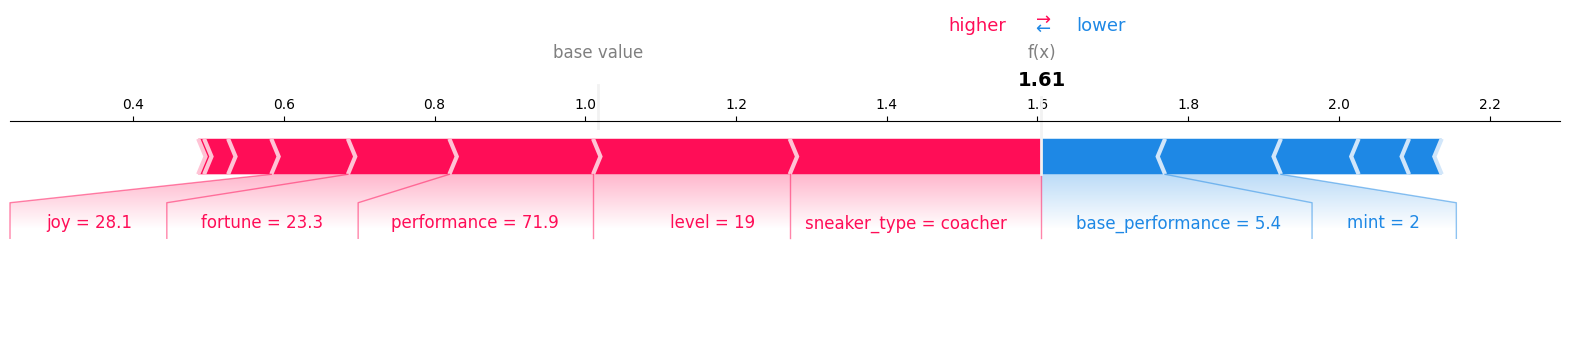

In [136]:
sample = pd.DataFrame(pd.Series(sneaker_dict)[model.feature_names_]).T
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)

iteritems is deprecated and will be removed in a future version. Use .items instead.


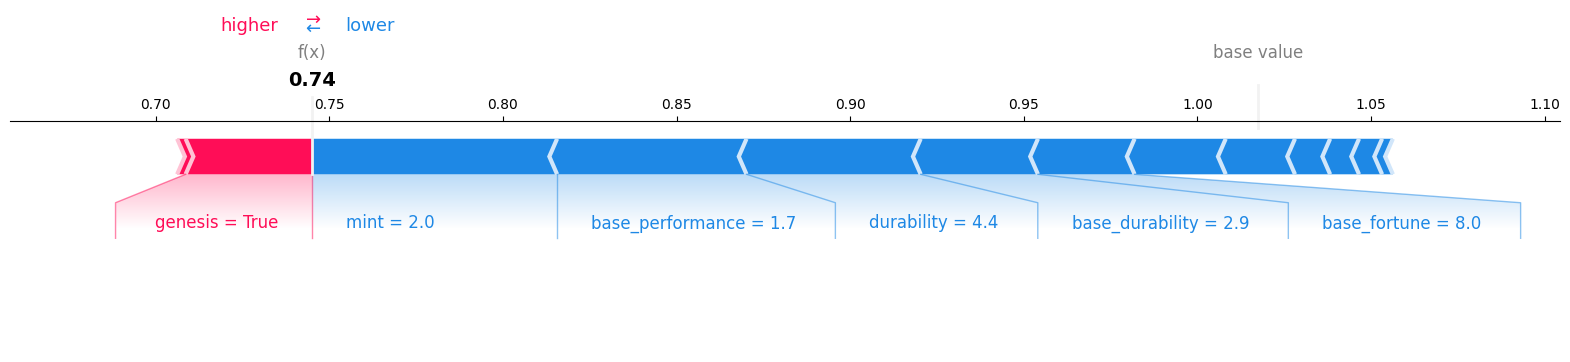

In [137]:
sample = data[data['token_id'] == 20928][model.feature_names_][:1]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(sample)
shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=True, matplotlib=True)
#plt.savefig(f'explainer_{VERSION}.png', dpi=700)
#plt.show()

In [138]:
#shap.force_plot(explainer.expected_value, shap_values[0,:], sample, show=False, matplotlib=True).savefig(f'sneaker_base_model_explainer_img.png', format = "png", dpi = 150, bbox_inches = 'tight')

# Box Model

## Data

In [139]:
data = pd.read_csv(f'{BD_FOLDER}/{BD_NAME}')

Columns (62,63,64,65,66,67) have mixed types. Specify dtype option on import or set low_memory=False.


In [140]:
#data.genesis = data.genesis.fillna(0).astype(int).astype(bool)

In [141]:
data = data[(data.item_type == 'box') & (data.event == 'buy')].copy().reset_index(drop=True)
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,mrk_floor__rarity_type_genesis,mrk_floor__rarity_type,mrk_floor__all,mkr_count__rarity_type_genesis_lvl_mint,mrk_count__rarity_type_genesis_lvl,mrk_count__rarity_type_genesis,mrk_count__rarity_type,mrk_count__sneaker_all,mrk_count__box_all,mrk_count__all
0,1664880293,49776,65160,buy,0x63b8e2463cb7a47888537c6b4faffdf550ee2e15,0x9c9ff7098114deb4b9188ca5eaf1ff9213391026,0.79,box,common,NaN,...,0.79,0.79,0.62,54.0,54.0,54.0,94.0,455.0,101.0,556.0
1,1664877618,49770,65850,buy,0x702b3a7f41467a74388b2ed3e6b0c4554e0becf7,0x093b8607b9e6dafb5d42e0c860701f71f33273c8,0.79,box,common,NaN,...,0.79,0.79,0.61,55.0,55.0,55.0,95.0,446.0,102.0,548.0
2,1664874953,49723,65148,buy,0x1d1332ae4d8f2b6551f1fe8e03a29cfc1fef2883,0xd0c78976ff9dba68970dd42ca62082305a3fd18c,0.85,box,common,NaN,...,0.80,0.80,0.58,54.0,54.0,54.0,94.0,449.0,101.0,550.0
3,1664874650,49749,65800,buy,0xc086823eeb70ac2084f1cb8aec1307ceac247aca,0x2100beb1eea62498a605fa447eb3e86e3a981ec3,0.84,box,common,NaN,...,0.80,0.80,0.58,55.0,55.0,55.0,95.0,447.0,102.0,549.0
4,1664873870,49710,65805,buy,0x401c21fddee405eca5a6dbc35df3e04da87ab447,0x9288af0e1835f4e63eefc42ee064ffdcbcf62263,0.86,box,common,NaN,...,0.80,0.80,0.59,56.0,56.0,56.0,96.0,445.0,103.0,548.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,1661070301,13989,33249,buy,0x3869363159f953feed0959fc23e32f60d784b249,0xf2e2a51537fac7b62234c57e1ef35c6dc35536d1,0.89,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1193,1661054035,13521,227,buy,0xfbe5e186feacd47fedfbc91e4c9b0c64db928784,0xd5da766c451b21ab962e99a34675102dd96eaab6,1.50,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1194,1661034370,13747,32215,buy,0x07a42ed43e24b0d23fe6b347378ccdac7c448397,0x5e56fc61fc07cba1367e8bccb0ef919116c71d74,0.98,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1195,1661033512,13544,32564,buy,0x560e7af378e08e0681e0df3cda652078a6c3cdb9,0x80cf6cf64b8fa2cd302d6c190182ee8589ce10ae,0.95,box,common,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
data = data[((~data['parent1_sneaker_type'].isna() & (~data['parent2_sneaker_type'].isna())) | (data['genesis']))].copy().reset_index(drop=True)

In [143]:
data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.sort_values('date')

In [144]:
len(data)

1197

In [145]:
len(data[data.date >= START_DATE])

831

In [146]:
data = data[data.date >= START_DATE].reset_index(drop=True).copy()

In [147]:
data[['wallet_first_sneaker_time',
       'time_ownership', 'wallet_box_mint', 'wallet_sneaker_mint',
       'time_level_up', 'time_level_up_for_mint', 'base_mint_price_amt',
       'base_mint_price_azy', 'base_mint_price_bnb']]

,wallet_first_sneaker_time,time_ownership,wallet_box_mint,wallet_sneaker_mint,time_level_up,time_level_up_for_mint,base_mint_price_amt,base_mint_price_azy,base_mint_price_bnb
0,1.659602e+09,6978.0,6.0,6.0,NaN,1800.0,300.0,200.0,0.676773
1,1.657800e+09,11145.0,8.0,6.0,NaN,1800.0,300.0,200.0,0.676012
2,1.657800e+09,23229.0,6.0,4.0,NaN,1800.0,300.0,200.0,0.677113
3,1.657802e+09,21564.0,6.0,5.0,NaN,1800.0,300.0,200.0,0.639683
4,1.657801e+09,38277.0,8.0,3.0,NaN,1800.0,300.0,200.0,0.642806
...,...,...,...,...,...,...,...,...,...
826,1.657800e+09,3304.0,14.0,13.0,NaN,1800.0,300.0,200.0,0.442632
827,1.663353e+09,420.0,3.0,0.0,NaN,1800.0,300.0,200.0,0.438613
828,1.657801e+09,2419.0,13.0,6.0,NaN,1800.0,300.0,200.0,0.440838
829,1.657802e+09,1705.0,19.0,17.0,NaN,1800.0,300.0,200.0,0.441340


In [148]:
data[['timestamp', 'mrk_id', 'token_id', 'event', 'genesis', 'parent1_sneaker_type', 'parent2_sneaker_type', 'date']]

,timestamp,mrk_id,token_id,event,genesis,parent1_sneaker_type,parent2_sneaker_type,date
0,1662164401,21798,40436,buy,False,hiker,hiker,2022-09-03 00:20:01
1,1662170890,21796,40464,buy,False,hiker,sprinter,2022-09-03 02:08:10
2,1662171007,21614,38512,buy,False,coacher,coacher,2022-09-03 02:10:07
3,1662181762,21801,40467,buy,False,ranger,ranger,2022-09-03 05:09:22
4,1662186301,21623,38529,buy,False,coacher,coacher,2022-09-03 06:25:01
...,...,...,...,...,...,...,...,...
826,1664873870,49710,65805,buy,False,ranger,ranger,2022-10-04 08:57:50
827,1664874650,49749,65800,buy,False,hiker,ranger,2022-10-04 09:10:50
828,1664874953,49723,65148,buy,False,hiker,hiker,2022-10-04 09:15:53
829,1664877618,49770,65850,buy,False,ranger,ranger,2022-10-04 10:00:18


In [149]:
data.genesis.value_counts()

False    784
True      47
Name: genesis, dtype: int64

In [150]:
sneaker_types = ['ranger', 'sprinter', 'hiker', 'coacher']

In [151]:
from itertools import combinations
sneaker_combs = list(combinations(sneaker_types, 2))

In [152]:
comb_features = []

for sneaker_comb in sneaker_combs:
    #print(sneaker_comb[0])
    feature_name = f'{sneaker_comb[0]}_{sneaker_comb[1]}'
    data[feature_name] = (((data['parent1_sneaker_type'] == sneaker_comb[0]) & (data['parent2_sneaker_type'] == sneaker_comb[1])) | ((data['parent1_sneaker_type'] == sneaker_comb[1]) & (data['parent2_sneaker_type'] == sneaker_comb[0])))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)
    #break

for sneaker_type in sneaker_types:
    feature_name = f'{sneaker_type}_{sneaker_type}'
    data[feature_name] = ((data['parent1_sneaker_type'] == sneaker_type) & (data['parent2_sneaker_type'] == sneaker_type))
    data[feature_name] = data[feature_name].astype(int)
    comb_features.append(feature_name)

In [153]:
data

,timestamp,mrk_id,token_id,event,wallet_from,wallet_to,price,item_type,rarity,sneaker_type,...,ranger_sprinter,ranger_hiker,ranger_coacher,sprinter_hiker,sprinter_coacher,hiker_coacher,ranger_ranger,sprinter_sprinter,hiker_hiker,coacher_coacher
0,1662164401,21798,40436,buy,0xc57ca482a3e1d0eef363166295962163b2f64ed0,0x710b6677ea43dc7cbf513248b896a6f28171b709,1.13,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
1,1662170890,21796,40464,buy,0xf7b7c0f111fe7bf762fc2c706aee194a39758e95,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.13,box,common,NaN,...,0,0,0,1,0,0,0,0,0,0
2,1662171007,21614,38512,buy,0x2a3f0c8349bde254599ed019a2d1994de06b7803,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.18,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
3,1662181762,21801,40467,buy,0x80dd92e3473e45c935edce170191810dc93bc56b,0x5492bae2e5b87a82e3803cdefdff51c4e280baaf,1.09,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
4,1662186301,21623,38529,buy,0x50975867d5c0bad1b78ebf4b06252be9bdb76c64,0x741d48c325f4d29e9961cc86239a96070b3a1f4e,1.20,box,common,NaN,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,1664873870,49710,65805,buy,0x401c21fddee405eca5a6dbc35df3e04da87ab447,0x9288af0e1835f4e63eefc42ee064ffdcbcf62263,0.86,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0
827,1664874650,49749,65800,buy,0xc086823eeb70ac2084f1cb8aec1307ceac247aca,0x2100beb1eea62498a605fa447eb3e86e3a981ec3,0.84,box,common,NaN,...,0,1,0,0,0,0,0,0,0,0
828,1664874953,49723,65148,buy,0x1d1332ae4d8f2b6551f1fe8e03a29cfc1fef2883,0xd0c78976ff9dba68970dd42ca62082305a3fd18c,0.85,box,common,NaN,...,0,0,0,0,0,0,0,0,1,0
829,1664877618,49770,65850,buy,0x702b3a7f41467a74388b2ed3e6b0c4554e0becf7,0x093b8607b9e6dafb5d42e0c860701f71f33273c8,0.79,box,common,NaN,...,0,0,0,0,0,0,1,0,0,0


In [154]:
comb_features

['ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [155]:
data['ranger_hiker'].sum()

80

## FE

In [156]:
data['sells_activity_24H'] = data['sell_count_24H'] / data['buy_count_24H']
data['sum_activity_24H'] = data['buy_count_24H'] + data['sell_count_24H'] + data['cancel_count_24H']

# Model

In [157]:
features = [
    'rarity', 
    'genesis',
    'buy_count_12H',
    'buy_count_24H',
    'sum_activity_24H',
    'sells_activity_24H',
    'min_price_all_24H',
    #'base_mint_price_amt',
    #'base_mint_price_azy', 
    #'base_mint_price_bnb',
    'price_bnb', 
    #'price_azy', 
    #'price_amt',
    #'wallet_from_buy_count',
    #'wallet_from_all_count', 
    *comb_features
    ]
cat_columns = ['rarity',]
cat_features = [0,]

In [158]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [159]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.24it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:02,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:03,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:03,  1.29it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:04,  1.28it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:05,  1.27it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:06,  1.26it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:07,  1.23it/s]iteritems is deprec

In [160]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.444,1.3219
MAE,0.090,0.0595
MSE,0.366,0.5932
RMSE,0.388,0.4713
MAPE,0.051,0.0128


In [161]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.444,1.3219
MAE,0.090,0.0595
MSE,0.366,0.5932
RMSE,0.388,0.4713
MAPE,0.051,0.0128


In [162]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.396, 'MAE': 0.09, 'MSE': 0.365, 'RMSE': 0.604, 'MAPE': 0.051}

iteritems is deprecated and will be removed in a future version. Use .items instead.


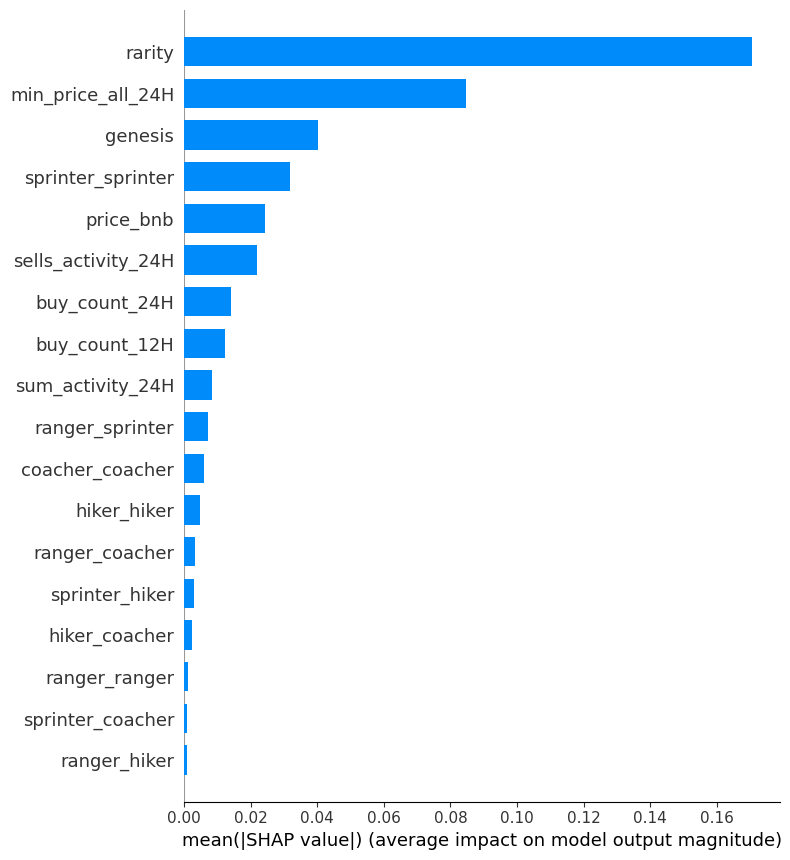

In [163]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar',)

## Fit Box Model on full data

In [164]:
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_model_{VERSION}.model')

Learning rate set to 0.039763
0:	learn: 0.7629844	total: 670us	remaining: 670ms
1:	learn: 0.7487201	total: 1.94ms	remaining: 968ms
2:	learn: 0.7360827	total: 3.15ms	remaining: 1.04s
3:	learn: 0.7233341	total: 4.33ms	remaining: 1.08s
4:	learn: 0.7103026	total: 5.58ms	remaining: 1.11s
5:	learn: 0.6979836	total: 6.58ms	remaining: 1.09s
6:	learn: 0.6861897	total: 7.86ms	remaining: 1.11s
7:	learn: 0.6748298	total: 8.77ms	remaining: 1.09s
8:	learn: 0.6633385	total: 9.57ms	remaining: 1.05s
9:	learn: 0.6523979	total: 10.4ms	remaining: 1.03s
10:	learn: 0.6416382	total: 11.1ms	remaining: 998ms
11:	learn: 0.6306363	total: 11.4ms	remaining: 941ms
12:	learn: 0.6197723	total: 12.2ms	remaining: 925ms
13:	learn: 0.6084997	total: 12.8ms	remaining: 904ms
14:	learn: 0.5988565	total: 13.6ms	remaining: 891ms
15:	learn: 0.5896941	total: 14.3ms	remaining: 877ms
16:	learn: 0.5801843	total: 15ms	remaining: 866ms
17:	learn: 0.5709147	total: 15.7ms	remaining: 855ms
18:	learn: 0.5615678	total: 16.2ms	remaining: 8

### Test

In [165]:
i = 250

In [166]:
box_dict = {}

features = data.columns

for feature in features:
    box_dict[feature] = data.iloc[i][feature]

box_dict['sum_activity_24H'] = box_dict['buy_count_24H'] + box_dict['sell_count_24H'] + box_dict['cancel_count_24H']
box_dict['sells_activity_24H'] = box_dict['sell_count_24H'] / box_dict['buy_count_24H']

box_dict

{'timestamp': 1662994885,
 'mrk_id': 27361,
 'token_id': 47029,
 'event': 'buy',
 'wallet_from': '0x0885157dbb0db47f63477b1d88c62a8b5193aefa',
 'wallet_to': '0xf06301c9b159e20d019995b4943f075b6b28e246',
 'price': 1.0,
 'item_type': 'box',
 'rarity': 'common',
 'sneaker_type': nan,
 'level': 0.0,
 'base_performance': nan,
 'base_fortune': nan,
 'base_joy': nan,
 'base_durability': nan,
 'performance': nan,
 'fortune': nan,
 'joy': nan,
 'durability': nan,
 'mint': nan,
 'parent1': 19505.0,
 'parent2': 19511.0,
 'genesis': False,
 'parent1_sneaker_type': 'ranger',
 'parent2_sneaker_type': 'sprinter',
 'price_bnb': 297.38936778,
 'price_azy': 0.09238833,
 'price_amt': 0.55592094,
 'wallet_from_buy_count': 2.0,
 'wallet_from_all_count': 9.0,
 'token_all_activity_3H': 0.0,
 'token_sell_activity_6H': 0.0,
 'buy_count_12H': 16.0,
 'buy_count_24H': 25,
 'buy_count_48H': 55.0,
 'sell_count_12H': 18.0,
 'sell_count_24H': 40,
 'sell_count_48H': 96.0,
 'cancel_count_12H': 9.0,
 'cancel_count_24H':

In [167]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')

template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']
template_data['buy_count_12H'] = box_dict['buy_count_12H']
template_data['buy_count_24H'] = box_dict['buy_count_24H']
template_data['sells_activity_24H'] = box_dict['sells_activity_24H']
template_data['sum_activity_24H'] = box_dict['sum_activity_24H']
template_data['min_price_all_24H'] = box_dict['min_price_all_24H']
template_data['wallet_from_buy_count'] = box_dict['wallet_from_buy_count']
template_data['wallet_from_all_count'] = box_dict['wallet_from_all_count']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity                   common
genesis                   False
buy_count_12H              16.0
buy_count_24H                25
sum_activity_24H             89
sells_activity_24H          1.6
min_price_all_24H           0.9
price_bnb                   NaN
ranger_sprinter               1
ranger_hiker                NaN
ranger_coacher              NaN
sprinter_hiker              NaN
sprinter_coacher            NaN
hiker_coacher               NaN
ranger_ranger               NaN
sprinter_sprinter           NaN
hiker_hiker                 NaN
coacher_coacher             NaN
wallet_from_buy_count       2.0
wallet_from_all_count       9.0
dtype: object

In [168]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.025

In [169]:
data.iloc[i]['price']

1.0

In [170]:
template_data['genesis'] = True

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.456

In [171]:
template_data['rarity'] = 'uncommon'

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

2.699

# Box Base Model

In [172]:
features = ['rarity', 'genesis', *comb_features]
cat_columns = ['rarity',]
cat_features = [0,]

In [173]:
features

['rarity',
 'genesis',
 'ranger_sprinter',
 'ranger_hiker',
 'ranger_coacher',
 'sprinter_hiker',
 'sprinter_coacher',
 'hiker_coacher',
 'ranger_ranger',
 'sprinter_sprinter',
 'hiker_hiker',
 'coacher_coacher']

In [174]:
X = data[features].reset_index(drop=True).copy()
y = data.price.reset_index(drop=True).copy()

In [175]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   rarity             831 non-null    object
 1   genesis            831 non-null    bool  
 2   ranger_sprinter    831 non-null    int64 
 3   ranger_hiker       831 non-null    int64 
 4   ranger_coacher     831 non-null    int64 
 5   sprinter_hiker     831 non-null    int64 
 6   sprinter_coacher   831 non-null    int64 
 7   hiker_coacher      831 non-null    int64 
 8   ranger_ranger      831 non-null    int64 
 9   sprinter_sprinter  831 non-null    int64 
 10  hiker_hiker        831 non-null    int64 
 11  coacher_coacher    831 non-null    int64 
dtypes: bool(1), int64(10), object(1)
memory usage: 72.4+ KB


In [176]:
skf = RepeatedKFold(
                n_splits=10,
                n_repeats=3,
                random_state=42,
            )

cv_split_idx = [(train_idx, valid_idx) for (train_idx, valid_idx) in skf.split(X, y)]

folds_scores = {}
oof_predicts = []
oof_y = []
feature_importance = {}

for i, (train_idx, valid_idx) in tqdm(enumerate(cv_split_idx)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    val_x, val_y = X.iloc[valid_idx], y.iloc[valid_idx]

    #build model
    # model = CatBoostRegressor(
    #     loss_function='MAPE',
    #     #loss_function='MAE',
    #     #iterations=1000,
    #     #learning_rate=0.01,
    #     depth=4,
    #     #l2_leaf_reg=0.2,
    #     #min_child_samples=10,
    #     #bagging_temperature=5,
    #     random_seed=42,
    #     )
    model = CatBoostRegressor(random_seed=42)

    # train_data = Pool(
    #     train_x, 
    #     train_y,
    #     cat_features=cat_features,
    #     )

    # Fit model 
    model.fit(#train_data,
        train_x, 
        train_y,
        #eval_set=(X_test, y_test),
        cat_features=cat_features,
        #plot=True,
        verbose=False,
        )

    pred = model.predict(val_x)
    pred = np.round(pred, 2)

    score = score_regression_simple(val_y, pred,)
    folds_scores[f'fold_{i+1}'] = score

    oof_predicts = [*oof_predicts, *pred]
    oof_y = [*oof_y, *val_y]

    feature_importance[f'fold_{i+1}'] = model.get_feature_importance(prettified=True)

0it [00:00, ?it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
1it [00:00,  1.84it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
2it [00:01,  1.88it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
3it [00:01,  1.92it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
4it [00:02,  1.92it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
5it [00:02,  1.92it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
6it [00:03,  1.88it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
7it [00:03,  1.89it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
8it [00:04,  1.88it/s]iteritems is deprecated and will be removed in a future version. Use .items instead.
9it [00:04,  1.90it/s]iteritems is deprec

In [177]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.656,0.2357
MAE,0.154,0.0560
MSE,0.313,0.5726
RMSE,0.379,0.4180
MAPE,0.131,0.0172


In [178]:
folds_scores = pd.DataFrame(folds_scores)
mean_fols_scores = pd.DataFrame()
mean_fols_scores['Score'] = round(folds_scores.T.mean(),3)
mean_fols_scores['std'] = round(folds_scores.T.std(), 4)
mean_fols_scores

,Score,std
R2,0.656,0.2357
MAE,0.154,0.0560
MSE,0.313,0.5726
RMSE,0.379,0.4180
MAPE,0.131,0.0172


In [179]:
oof_score = score_regression_simple(oof_y, oof_predicts,)
oof_score

{'R2': 0.484, 'MAE': 0.154, 'MSE': 0.312, 'RMSE': 0.559, 'MAPE': 0.131}

iteritems is deprecated and will be removed in a future version. Use .items instead.


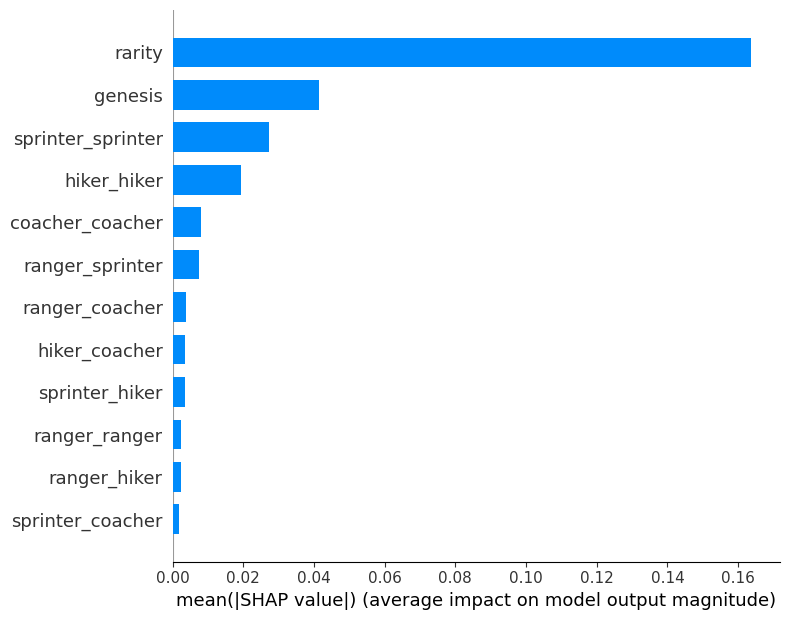

In [180]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_x)
shap.summary_plot(shap_values, features=X, feature_names=X.columns, plot_type='bar')

## Fit on full data

In [181]:
#build model
# model = CatBoostRegressor(
#         loss_function='MAPE',
#         #loss_function='MAE',
#         #iterations=1000,
#         #learning_rate=0.01,
#         depth=4,
#         #l2_leaf_reg=0.2,
#         #min_child_samples=10,
#         #bagging_temperature=5,
#         random_seed=42,
#     )
model = CatBoostRegressor()

# Fit model 
model.fit(X, y, cat_features=cat_features,)
model.save_model(f'./models/box_base_model_{VERSION}.model')

Learning rate set to 0.039763
0:	learn: 0.7652689	total: 1.29ms	remaining: 1.29s
1:	learn: 0.7525863	total: 2.12ms	remaining: 1.06s
2:	learn: 0.7431038	total: 2.85ms	remaining: 946ms
3:	learn: 0.7323379	total: 3.51ms	remaining: 873ms
4:	learn: 0.7213855	total: 3.91ms	remaining: 778ms
5:	learn: 0.7120349	total: 4.51ms	remaining: 748ms
6:	learn: 0.7046797	total: 4.85ms	remaining: 688ms
7:	learn: 0.6948031	total: 5.21ms	remaining: 646ms
8:	learn: 0.6848286	total: 6.07ms	remaining: 668ms
9:	learn: 0.6781793	total: 6.34ms	remaining: 628ms
10:	learn: 0.6693271	total: 6.89ms	remaining: 620ms
11:	learn: 0.6602008	total: 7.68ms	remaining: 632ms
12:	learn: 0.6550111	total: 8.01ms	remaining: 608ms
13:	learn: 0.6468050	total: 8.48ms	remaining: 598ms
14:	learn: 0.6384490	total: 9.07ms	remaining: 596ms
15:	learn: 0.6317997	total: 9.38ms	remaining: 577ms
16:	learn: 0.6247544	total: 10.3ms	remaining: 594ms
17:	learn: 0.6176037	total: 10.8ms	remaining: 591ms
18:	learn: 0.6111578	total: 11.3ms	remaining

## Test

In [182]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data[model.feature_names_])
predict_price = np.round(predict_price, 3)
predict_price

2.69

In [183]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'sprinter',
}

In [184]:
template_data = pd.Series(index = model.feature_names_, dtype='int64')
template_data['rarity'] = box_dict['rarity']
template_data['genesis'] = box_dict['genesis']

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker          NaN
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [185]:
if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"

    template_data[feature_name] = 1

template_data

rarity               common
genesis               False
ranger_sprinter         NaN
ranger_hiker            NaN
ranger_coacher          NaN
sprinter_hiker            1
sprinter_coacher        NaN
hiker_coacher           NaN
ranger_ranger           NaN
sprinter_sprinter       NaN
hiker_hiker             NaN
coacher_coacher         NaN
dtype: object

In [186]:
MODEL_DIR = './models/'
MODEL_NAME = f'box_base_model_{VERSION}.model'

model = CatBoostRegressor()      # parameters not required.
model.load_model(MODEL_DIR+MODEL_NAME)

predict_price = model.predict(template_data)
predict_price = np.round(predict_price, 3)
predict_price

1.001

In [187]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'coacher',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.156

In [188]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'coacher',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.156

In [189]:
box_dict = {
    'rarity': 'common',
    'genesis': True,
    'parent1_sneaker_type': '',
    'parent2_sneaker_type': '',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.479

In [190]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'hiker',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.043

In [191]:
box_dict = {
    'rarity': 'common',
    'genesis': False,
    'parent1_sneaker_type': 'hiker',
    'parent2_sneaker_type': 'ranger',
}

data_tmp = pd.Series(index = model.feature_names_, dtype='int64')
data_tmp['rarity'] = box_dict['rarity']
data_tmp['genesis'] = box_dict['genesis']

if not box_dict['genesis']:
    feature_name = f"{box_dict['parent1_sneaker_type']}_{box_dict['parent2_sneaker_type']}"
    if feature_name not in model.feature_names_:
        feature_name = f"{box_dict['parent2_sneaker_type']}_{box_dict['parent1_sneaker_type']}"
    data_tmp[feature_name] = 1

predict_price = model.predict(data_tmp)
predict_price = np.round(predict_price, 3)
predict_price

1.011

фитчи из блока:
- маркер перекупа
- количество кроссов у продающего
- базовые хорактеристики
- разницу между базовыми
- сорость прошлой покупки
- количество перепродаж
- количество перевыставлений
- сколько времени весит на маркете кросс
- время выставления
- время после последнего апдейта цены
- количество обновлений цены (одним владельцем)
- окупаемость 
- количество транзакций на кросовке
- количество минта на акке продавца
- когда начал работать продовец с ази
- прошлая цена продажи (и их разница)
- время владения кроссом одним продавцом


Данные по рынку:
- количество транзакций на токене
- количество ордеров (бай, селл, кансел)
- количество ордеров за периоды (бай, селл, кансел)
- разница среднего количества ордеров за период и текущего за день.
- количество холдеров
- количество кроссовок вообще
- количество новых кросовок за периоды (день, 3 дня, неделя и тд)
- количество кроссовок сейчас на рынке
- разница от всего кроссов и сейчас на рынке
- цена токена атм
- цена токена azy
- цена бнб и битка
- изменение цены бнб и битка
- изменение соотношения генезис кроссов к обычным
- изменение соотношения по классам
- цены на боксы
- количество боксов на рынке
- количество кроссов/боксы
- стоимость минта
- прибыльность минта 
- день недели # 7 мин
- выходные # 7 мин
- средние цены кроссов 0 уровня по типам за периоды # 30 мин

внешние данные:
- количество подпищеков в телеге твите



In [192]:
# import ast
# import json

In [193]:
# json_data = "{'token_id': 22259, 'rarity': 'common', 'sneaker_type': 'hiker', 'genesis': False, 'level': 5, 'base_performance': 3.0, 'base_fortune': 2.7, 'base_joy': 7.3, 'base_durability': 3.5, 'performance': 16.5, 'fortune': 4.2, 'joy': 10.8, 'durability': 8.5, 'mint': 2, 'wallet_from_buy_count': 0, 'wallet_from_all_count': 1, 'buy_count_12H': 97, 'buy_count_24H': 191, 'sell_count_24H': 430, 'cancel_count_24H': 238, 'min_price_all_24H': 0.6, 'min_price_by_rarity_genesis_type_level_mint_24H': 0.7, 'min_price_by_rarity_genesis_type_24H': 0.7, 'token_all_activity_3H': 1, 'token_sell_activity_6H': 1, 'explain_models': True}"
# json_data = ast.literal_eval(json_data)

In [194]:
# print(json.dumps(json_data))

In [195]:
# import requests

# r = requests.post(
#     "http://65.21.94.236:8003/sneaker_predict_price", 
#     data=json.dumps(json_data))
# print(r.status_code, r.reason)

In [196]:
#output = json.loads(r.text)

In [197]:
# from PIL import Image
# import base64
# import io 

# im = Image.open(io.BytesIO(base64.b64decode(output['sneaker_model_predict_explain_img'])))
# im.show()

групировку делать по sell оредерам